# Projet AIOI

https://www.kaggle.com/c/stanford-covid-vaccine

## Les imports

In [70]:
%%capture

import numpy as np
import pandas as pd
from collections import Counter
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import tensorflow as tf

# Modules
from __modules__.file import read_json, read_npy
import __modules__.visualisation as plot

## Charger les données

In [2]:
arn_train = read_json('../Data/train.json')
arn_test = read_json('../Data/test.json')

In [3]:
arn_train.columns, arn_test.columns

(Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
        'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
        'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
        'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
        'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
       dtype='object'),
 Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
        'seq_length', 'seq_scored'],
       dtype='object'))

## Les données

In [4]:
arn_train.shape, arn_train['id'].nunique(), arn_test.shape

((2400, 19), 2400, (3634, 7))

<div class="alert alert-block alert-warning">
    Nettoyer les données, i.e ne prendre en compte que les ARN qui ont un <bold>SN_filter de 1<bold>
</div>

In [5]:
arn_train = arn_train.query('SN_filter == 1')
arn_train.shape

(1589, 19)

In [6]:
arn_train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [7]:
arn_test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [8]:
Counter(arn_train['seq_length']), Counter(arn_test['seq_length'])

(Counter({107: 1589}), Counter({107: 629, 130: 3005}))

### Input x

In [9]:
col_names = ['sequence', 'structure', 'predicted_loop_type']
X_train = arn_train[col_names]
X_test = arn_test.query('seq_length == 107')[col_names]  # Sélection des séquences qui ont une taille de 107
X_train.shape, X_test.shape

((1589, 3), (629, 3))

> One hot encoding des séquences

In [10]:
def x_sequence(X):
    dico_seq = {'A': 0, 'U': 1, 'G': 2, 'C': 3}
    x_seq = []
    
    for seq in X:
        tmp = []
        for base in seq:
            tmp.append(dico_seq[base])
        x_seq.append(to_categorical(tmp, num_classes=4, dtype=int))
    
    return np.array(x_seq)

x_seq_train, x_seq_test = x_sequence(X_train['sequence']), x_sequence(X_test['sequence'])
x_seq_train.shape, x_seq_test.shape

((1589, 107, 4), (629, 107, 4))

> One hot encoding des structures

In [11]:
def x_structure(X):
    dico_struc = {'(': 0, ')': 1, '.': 2}
    x_struc = []

    for struc in X:
        tmp = []
        for symbol in struc:
            tmp.append(dico_struc[symbol])
        x_struc.append(to_categorical(tmp, num_classes=3, dtype=int))
    
    return np.array(x_struc)

x_struc_train, x_struc_test = x_structure(X_train['structure']), x_structure(X_test['structure'])
x_struc_train.shape, x_struc_test.shape

((1589, 107, 3), (629, 107, 3))

> One hot encoding des types de boucles prédits

In [12]:
def x_predicted_loops(X):
    dico_loops = {'S': 0, 'E': 1, 'B': 2, 'H': 3, 'M': 4, 'I': 5, 'X': 6}
    x_loops = []

    for loops in X:
        tmp = []
        for loop_type in loops:
            tmp.append(dico_loops[loop_type])
        x_loops.append(to_categorical(tmp, num_classes=7, dtype=int))
        
    return np.array(x_loops)

x_loops_train, x_loops_test = x_predicted_loops(X_train['predicted_loop_type']), x_predicted_loops(X_test['predicted_loop_type'])
x_loops_train.shape, x_loops_test.shape

((1589, 107, 7), (629, 107, 7))

> Regroupement dans une seul matrice de dimension (2400, 107, 14)

Avec

- 2400: le nombre d'ARN
- 107: la taille des séquences
- 14: le nombre de classes (4+3+7)

In [13]:
def X_concatenation(x_seq, x_struc, x_loops):
    x = []
    for i in range(len(x_seq)):
        x.append(np.concatenate((x_seq[i], x_struc[i], x_loops[i]), axis=1))
    return np.array(x)

x_train, x_test = X_concatenation(x_seq_train, x_struc_train, x_loops_train), X_concatenation(x_seq_test, x_struc_test, x_loops_test)
x_train.shape, x_test.shape

((1589, 107, 14), (629, 107, 14))

### Output y

In [15]:
col_names = ['deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
Y_output = arn_train[col_names]
Y_output.shape

(1589, 4)

> Formatage Y_output

In [16]:
def formatage_youtput(Y_output):
    new_youtput = []
    deg_mg_ph = Y_output['deg_Mg_pH10']
    deg_ph = Y_output['deg_pH10']
    deg_mg_c = Y_output['deg_Mg_50C']
    deg_c = Y_output['deg_50C']

    for i in Y_output.index:
        tmp = []
        for j in range(len(deg_c[i])):
            tmp.append([deg_mg_ph[i][j], deg_ph[i][j], deg_mg_c[i][j], deg_c[i][j]])
        new_youtput.append(tmp)

    return np.array(new_youtput)
        
y_train = formatage_youtput(Y_output)
y_train.shape

(1589, 68, 4)

# Modèle keras 

## Modèle simple

In [21]:
def model_simple():
    # Convolution layers 
    input_ = layers.Input(shape = (107,14))
    conv_1 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(input_)
    conv_2 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_1)
    conv_3 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_2)
    
    # Resnet layers - simple
    resnet = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_3)
    resnet = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(resnet)
    conc_1 = layers.Add()([conv_3, resnet])
   
    # Output layer - resize shape of the data to fit with the ouput (68,4) 
    output = layers.Conv1D(filters=4, kernel_size=(20,), activation="relu")(conc_1)
    output = layers.Conv1D(filters=4, kernel_size=(20,), activation="relu")(output)
    output = layers.Conv1D(filters=4, kernel_size=(2,), activation="relu")(output)

    # Compilation
    model = models.Model(inputs=input_, outputs=output)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
    # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model_simple()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 107, 14)      0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 107, 107)     4601        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 107, 107)     34454       conv1d_9[0][0]                   
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 107, 107)     34454       conv1d_10[0][0]                  
____________________________________________________________________________________________

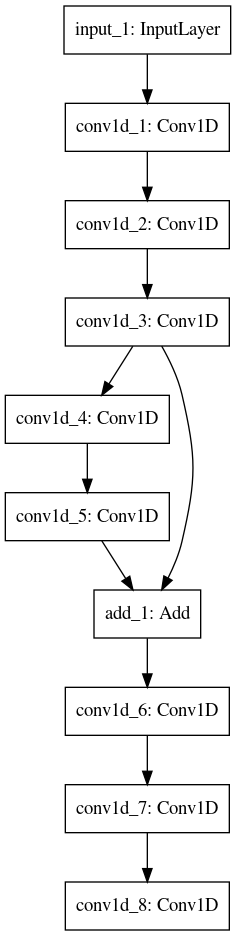

In [18]:
plot_model(model)

In [17]:
fit_out = model.fit(x=x_train, y=y_train, epochs=5, batch_size=30, verbose=1, validation_split=0.2)

Train on 1271 samples, validate on 318 samples
Epoch 1/5
1271/1271 [==============================] - 5s 4ms/step - loss: 0.2928 - accuracy: 0.3122 - val_loss: 0.2670 - val_accuracy: 0.2782
Epoch 2/5
1271/1271 [==============================] - 4s 4ms/step - loss: 0.2279 - accuracy: 0.3272 - val_loss: 0.2583 - val_accuracy: 0.2794
Epoch 3/5
1271/1271 [==============================] - 5s 4ms/step - loss: 0.1899 - accuracy: 0.2714 - val_loss: 0.1815 - val_accuracy: 0.2598
Epoch 4/5
1271/1271 [==============================] - 4s 3ms/step - loss: 0.1775 - accuracy: 0.2684 - val_loss: 0.1907 - val_accuracy: 0.2791
Epoch 5/5
1271/1271 [==============================] - 4s 3ms/step - loss: 0.1668 - accuracy: 0.2786 - val_loss: 0.1599 - val_accuracy: 0.2799


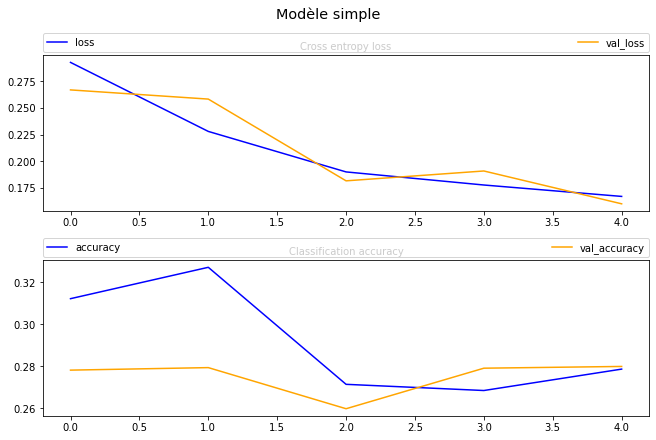

<Figure size 432x288 with 0 Axes>

In [20]:
plot.summarize_model(fit_out.history, "Modèle simple")

> Optimisation à faire

- Prise en compte d'un learning rate
- Comparaison pour chaque modèle de la loss, val loss, accuracy & val accuracy en fonction d'un learning rate donné => le but ici sera de comparé pour chaque modèle créé le "meilleur"

In [104]:
def resize_shape_data(model):
    model = layers.Conv1D(filters=4, kernel_size=(20,), activation="relu")(model)
    model = layers.Conv1D(filters=4, kernel_size=(20,), activation="relu")(model)
    model = layers.Conv1D(filters=4, kernel_size=(2,), activation="relu")(model)
    
    return model


def model_simple(input_shape, learning_rate):
    # Convolution layers 
    input_ = layers.Input(shape = input_shape)
    conv_1 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(input_)
    conv_2 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_1)
    conv_3 = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_2)
    
    # Resnet layers - simple
    resnet = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(conv_3)
    resnet = layers.Conv1D(filters=107, kernel_size=(3,), activation="relu", padding = "same")(resnet)
    conc_1 = layers.Add()([conv_3, resnet])
   
    # Output layer - resize shape of the data to fit with the ouput (68,4) 
    output = resize_shape_data(conc_1)
    model = models.Model(inputs=input_, outputs=output)
    
    # Compilation
    opt = optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    
    return model


def define_models(x_train, y_train):
    input_shape = (107,14) 
    learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5]  # learning rate à appliquer sur chaque modèle
    list_model = [model_simple]  # liste des modèles qu'on va appliquer - 1 seul implémenté pour l'instant
    fit_out = {}
    
    for model in list_model:
        fit_out[model.__name__] = []
        print(model.__name__)
        for lr in learning_rates:
            check(learning_rates.index(lr))
            mdl = model(input_shape, lr)
            # plot_model(model)
            fit = mdl.fit(x=x_train, y=y_train, epochs=30, batch_size=30, verbose=0, validation_split=0.2)
            fit_out[model.__name__].append(fit)
            
    return fit_out
    
def check(i):
    print("{} / 6".format(i+1), end="\t")
    
fit_out = define_models(x_train, y_train)

model_simple
1 / 6	2 / 6	3 / 6	4 / 6	5 / 6	6 / 6	

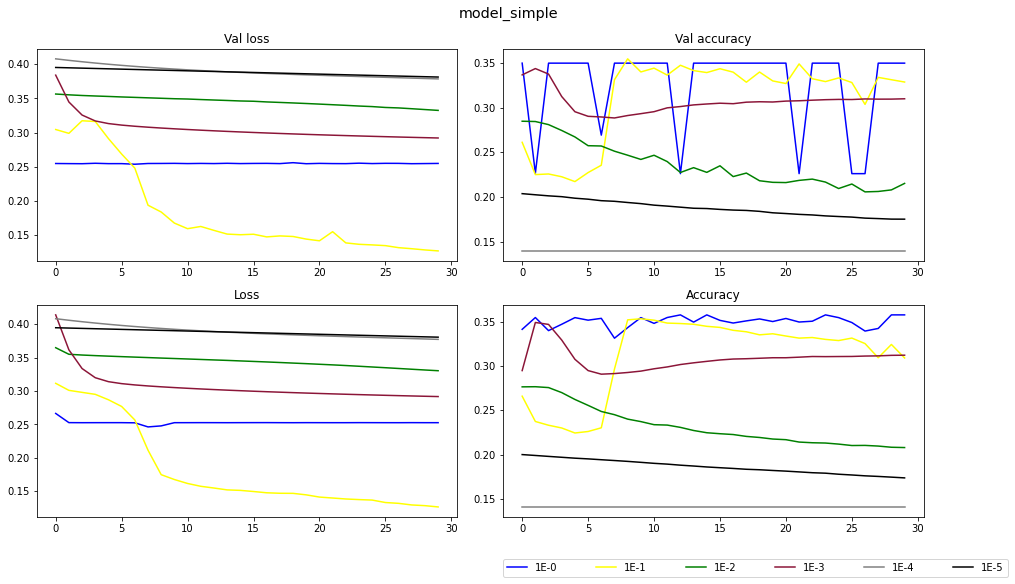

In [105]:
for mdl, values in fit_out.items():
    val_loss, val_accuracy = [], []
    loss, accuracy = [], []
    for fit in values:
        val_loss.append(fit.history['val_loss'])
        val_accuracy.append(fit.history['val_accuracy'])
        loss.append(fit.history['loss'])
        accuracy.append(fit.history['accuracy'])
        
    label = ['1E-0', '1E-1', '1E-2', '1E-3', '1E-4', '1E-5']
    title = ['Val loss', 'Val accuracy', 'Loss', 'Accuracy']
    color = ['blue', 'yellow', 'green', '#8b1538', 'grey', 'black']
    
    fig, axs = plt.subplots(2, 2, figsize=(14,8), constrained_layout=True)

    for i in range(len(val_loss)):
        axs[0][0].plot(val_loss[i], color=color[i], label=label[i])
        axs[0][1].plot(val_accuracy[i], color=color[i], label=label[i])
        axs[1][0].plot(loss[i], color=color[i], label=label[i])
        axs[1][1].plot(accuracy[i], color=color[i], label=label[i])
        
    axs[0][0].set_title(title[0])
    axs[0][1].set_title(title[1])
    axs[1][0].set_title(title[2])
    axs[1][1].set_title(title[3])
    
    # Ajouter la légende au dessus du plot sans changer sa taille
    axs[1][1].legend(loc=1, bbox_to_anchor=(0., 0., 1.2, -0.2), ncol=6, 
               borderaxespad=0., mode='expand', fontsize='medium')
        
    fig.suptitle(mdl, fontsize="x-large")